In [0]:
import pickle
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import os
os.listdir('/content/gdrive/My Drive/Colab Notebooks/Data_sets/chatbot')

['train_qa.txt', 'test_qa.txt']

In [0]:
with open("/content/gdrive/My Drive/Colab Notebooks/Data_sets/chatbot/train_qa.txt", "rb") as fp:  
    train_data =  pickle.load(fp)

In [0]:
with open("/content/gdrive/My Drive/Colab Notebooks/Data_sets/chatbot/test_qa.txt", "rb") as fp:   
    test_data =  pickle.load(fp)

In [17]:
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [18]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [19]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [20]:
train_data[0][2]

'no'

In [0]:
vocab = set()
all_data = test_data + train_data
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

vocab.add('no')
vocab.add('yes')

In [0]:
vocab_len = len(vocab) + 1 #extra space to hold a 0 for Keras's pad_sequences

In [0]:
max_story_len = max([len(data[0]) for data in all_data])

In [0]:
max_question_len = max([len(data[1]) for data in all_data])

In [25]:
max_question_len

6

In [26]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [0]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [28]:
tokenizer.word_index

{'.': 21,
 '?': 25,
 'apple': 16,
 'back': 5,
 'bathroom': 31,
 'bedroom': 9,
 'daniel': 20,
 'discarded': 23,
 'down': 27,
 'dropped': 18,
 'football': 1,
 'garden': 7,
 'got': 4,
 'grabbed': 3,
 'hallway': 12,
 'in': 22,
 'is': 17,
 'john': 15,
 'journeyed': 14,
 'kitchen': 8,
 'left': 37,
 'mary': 32,
 'milk': 19,
 'moved': 36,
 'no': 35,
 'office': 30,
 'picked': 33,
 'put': 29,
 'sandra': 26,
 'the': 28,
 'there': 11,
 'to': 6,
 'took': 13,
 'travelled': 10,
 'up': 24,
 'went': 2,
 'yes': 34}

In [0]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [0]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [31]:
len(train_story_text)

10000

In [0]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
        
    for story, query, answer in data:       
        x = [word_index[word.lower()] for word in story]
        
        xq = [word_index[word.lower()] for word in query]       
        y = np.zeros(len(word_index) + 1)        
        y[word_index[answer]] = 1        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=max_story_len),pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [0]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [35]:
answers_train.shape

(10000, 38)

In [37]:
answers_train[1]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0.])

In [38]:
queries_train.shape

(10000, 6)

In [39]:
inputs_train.shape

(10000, 156)

In [0]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [0]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [0]:
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [44]:
vocab_size = len(vocab) + 1
# Input gets embedded to a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(Dropout(0.3))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [45]:
input_encoder_m.output

<tf.Tensor 'dropout_1/cond/Merge:0' shape=(?, ?, 64) dtype=float32>

In [0]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [49]:
input_encoder_c.output

<tf.Tensor 'dropout_2/cond/Merge:0' shape=(?, ?, 6) dtype=float32>

In [0]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [51]:
question_encoder.output

<tf.Tensor 'dropout_3/cond/Merge:0' shape=(?, 6, 64) dtype=float32>

In [0]:
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [0]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [56]:
match

<tf.Tensor 'activation_1/truediv:0' shape=(?, 156, 6) dtype=float32>

In [0]:

response = add([match, input_encoded_c])  
response = Permute((2, 1))(response)  

In [58]:
response

<tf.Tensor 'permute_1/transpose:0' shape=(?, 6, 156) dtype=float32>

In [0]:
answer = concatenate([response, question_encoded])

In [60]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(?, 6, 220) dtype=float32>

In [0]:
answer = LSTM(32)(answer) 

In [0]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)

In [0]:
answer = Activation('softmax')(answer)

model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [64]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [66]:
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=10,validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 6s 597us/step - loss: 0.6952 - acc: 0.4989 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 2/10
10000/10000 [==============================] - 6s 609us/step - loss: 0.6950 - acc: 0.4986 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 3/10
10000/10000 [==============================] - 6s 601us/step - loss: 0.6954 - acc: 0.4950 - val_loss: 0.6932 - val_acc: 0.5030
Epoch 4/10
10000/10000 [==============================] - 6s 617us/step - loss: 0.6953 - acc: 0.4965 - val_loss: 0.6934 - val_acc: 0.4970
Epoch 5/10
10000/10000 [==============================] - 6s 599us/step - loss: 0.6951 - acc: 0.4993 - val_loss: 0.6949 - val_acc: 0.5030
Epoch 6/10
10000/10000 [==============================] - 6s 610us/step - loss: 0.6941 - acc: 0.5101 - val_loss: 0.6935 - val_acc: 0.4920
Epoch 7/10
10000/10000 [==============================] - 6s 619us/step - loss: 0.6940 - acc: 0.5062 - val_loss: 0.6918 - v

In [0]:
filename = '/content/gdrive/My Drive/Colab Notebooks/Data_sets/chatbot/chatbot_10_epochs.h5'
model.save(filename)

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


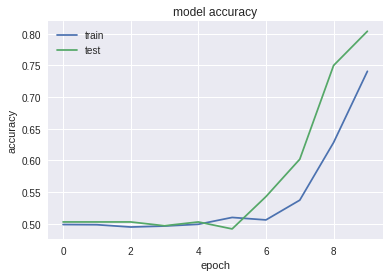

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [0]:
my_question = "Is the football in the garden ?"

In [71]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [0]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [0]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [0]:
pred_results = model.predict(([ my_story, my_ques]))

In [75]:
pred_results

array([[3.3158210e-10, 1.4610922e-10, 1.9350052e-10, 2.8271577e-10,
        2.3463723e-10, 2.5600694e-10, 4.6691856e-10, 3.0494962e-10,
        3.9153691e-10, 4.2236598e-10, 1.9410157e-10, 3.5744555e-10,
        2.9595373e-10, 2.3228877e-10, 2.8965708e-10, 1.8080561e-10,
        4.4830634e-10, 2.1176332e-10, 1.7953959e-10, 3.2727054e-10,
        2.8415975e-10, 4.1582729e-10, 3.4200717e-10, 4.3111065e-10,
        1.5720622e-10, 3.6251260e-10, 3.7276510e-10, 2.0545483e-10,
        2.3884009e-10, 4.3545592e-10, 4.5958234e-10, 4.0805989e-10,
        1.6261714e-10, 2.3474825e-10, 7.8523153e-01, 2.1476847e-01,
        5.4661031e-10, 2.4948815e-10]], dtype=float32)

In [0]:
val_max = np.argmax(pred_results[0])

In [77]:
val_max

34

In [0]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [79]:
k

'yes'

In [80]:
print("Probability of certainty was: ", pred_results[0][val_max])

Probability of certainty was:  0.78523153
